In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import shutil
import os
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
path = Path("../data/airbus-ship/")
files = list(path.iterdir())

In [3]:
sys.path.append("../fastai/old")
from fastai.conv_learner import *

### Coast preds

In [23]:
coast_val = pd.read_csv(path/"team_data/classifier_coast1_fold1_predsraw.csv" )

In [24]:
coast_val.shape

(193011, 3)

In [32]:
coast_val['ImageId'] = coast_val['ImageId'].apply(lambda x: x.split("/")[-1])

In [33]:
coast_val.head()

,ImageId,0,1
0,0001_001.png,0.998917,0.001083
1,0001_002.png,0.999357,0.000643
2,0001_003.png,0.999508,0.000492
3,0001_004.png,0.999393,0.000607
4,0001_005.png,0.999471,0.000529


In [26]:
coast_test = pd.read_csv(path/"team_data/classifier_coast1_fold2_test_predsraw.csv" )

In [27]:
coast_test.shape

(17291, 3)

In [28]:
coast_test.head()

,ImageId,0,1
0,00002bd58.jpg,9.993741e-01,0.000626
1,00015efb6.jpg,9.995047e-01,0.000495
2,00023d5fc.jpg,9.997459e-01,0.000254
3,000367c13.jpg,2.860576e-12,1.000000
4,0008ca6e9.jpg,9.993843e-01,0.000616


### Binary preds 

In [156]:
cls_fold_preds = pd.read_csv(path/"team_data/stacking/classification_fold_preds.csv")
cls_test_preds = pd.read_csv(path/"team_data/stacking/classification_test_preds.csv", usecols=[1,2])

In [157]:
cls_fold_preds.shape, cls_test_preds.shape

((48912, 2), (15606, 2))

In [158]:
cls_fold_preds.head()

,fname,proba
0,team_data/mosaic_tiles/2675_003.png,0.000197
1,team_data/mosaic_tiles/2612_006.png,0.000581
2,team_data/mosaic_tiles/0477_120.png,0.000633
3,team_data/mosaic_tiles/2675_002.png,0.000636
4,team_data/mosaic_tiles/0609_005.png,0.000676


In [159]:
cls_test_preds.head()

,ImageId,has_ship_proba
0,c7b10873e.jpg,0.000571
1,563b384e1.jpg,0.154543
2,b51dde87a.jpg,0.000012
3,521d1426a.jpg,0.036694
4,4b3ca4cb6.jpg,0.000053


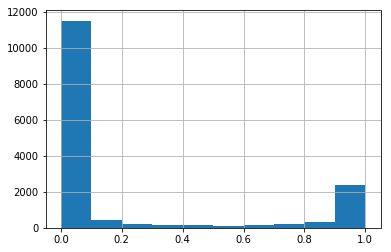

In [160]:
cls_test_preds.has_ship_proba.hist()

### Mask preds

In [ ]:
from fastai.models.unet import *
from fastai.dataset import *
from fastai.core import *

FOLD = 5

fold_csv = f'../data/airbus-ship/team_data/folds/classifierC_hasships_{FOLD}_val_index.csv'


MASKS_FN = path/"team_data/ships_train_tiles_all.csv"
TRAIN_DN = path/"team_data/mosaic_tiles"
MASKS_DN = path/"team_data/mosaic_tiles_masks"

def split_by_idx(idxs, *a):
    mask = np.zeros(len(a[0]),dtype=bool)
    mask[np.array(idxs)] = True
    return [(o[mask],o[~mask]) for o in a]
    
masks_csv = pd.read_csv(MASKS_FN)
x_fns = np.array([Path(TRAIN_DN)/f'{o}' for o in masks_csv['fn']]) 
y_fns = np.array([Path(MASKS_DN)/f'{o}' for o in masks_csv['fn']]) 
val_idxs = np.loadtxt(fold_csv, dtype=int)
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_fns, y_fns)

TRN_X = trn_x
TRN_Y = trn_y

VAL_X = val_x
VAL_Y = val_y

class FilesEncodedDataset(BaseDataset):
    def __init__(self, fnames, fnames2, transform, path):
        self.fnames = fnames
        self.fnames2 = fnames2
        self.path = path
        super().__init__(transform)
    
    def get_sz(self): return self.transform.sz
    def get_x(self, i): return open_image(self.fnames[i])
    def get_y(self, i): 
        
        mask = open_image(self.fnames2[i])[:,:,0]
        return mask
        
    def get_n(self): return len(self.fnames)
    def get_c(self): return 0

    def resize_imgs(self, targ, new_path):
        dest = resize_imgs(self.fnames, targ, self.path, new_path)
        return self.__class__(self.fnames, self.y, self.transform, dest)

    def denorm(self,arr):
        """Reverse the normalization done to a batch of images.

        Arguments:
            arr: of shape/size (N,3,sz,sz)
        """
        if type(arr) is not np.ndarray: arr = to_np(arr)
        if len(arr.shape)==3: arr = arr[None]
        return self.transform.denorm(np.rollaxis(arr,1,4))
    
    
class Transform():
    """ A class that represents a transform.

    All other transforms should subclass it.
    All subclasses should override
    do_transform.

    Arguments
    ---------
        tfm_y : TfmType
            type of transform
    """
    def __init__(self, tfm_y=TfmType.NO):
        self.tfm_y=tfm_y
        self.store = threading.local()

    def set_state(self): pass
    def __call__(self, x, y):
        self.set_state()
        x,y = ((self.transform(x),y) if self.tfm_y==TfmType.NO
                else self.transform(x,y) if self.tfm_y in (TfmType.PIXEL, TfmType.CLASS)
                else self.transform_coord(x,y))
        return x, y

    def transform_coord(self, x, y): return self.transform(x),y

    def transform(self, x, y=None):
        x = self.do_transform(x,False)
        return (x, self.do_transform(y,True)) if y is not None else x

    @abstractmethod
    def do_transform(self, x, is_y): raise NotImplementedError
        
        
        
class RandomLighting(Transform):
    def __init__(self, b, c, tfm_y=TfmType.NO):
        super().__init__(tfm_y)
        self.b,self.c = b,c

    def set_state(self):
        self.store.b_rand = rand0(self.b)
        self.store.c_rand = rand0(self.c)

    def do_transform(self, x, is_y):
        if is_y and self.tfm_y != TfmType.PIXEL: return x
        b = self.store.b_rand
        c = self.store.c_rand
        c = -1/(c-1) if c<0 else c+1
        x = lighting(x, b, c)
        return x
    
class RandomDihedral(CoordTransform):
    """
    Rotates images by random multiples of 90 degrees and/or reflection.
    Please reference D8(dihedral group of order eight), the group of all symmetries of the square.
    """
    def set_state(self):
        self.store.rot_times = random.randint(0,3)
        self.store.do_flip = random.random()<0.5

    def do_transform(self, x, is_y):
        x = np.rot90(x, self.store.rot_times)
        return np.fliplr(x).copy() if self.store.do_flip else x
    
def rotate_cv(im, deg, mode=cv2.BORDER_CONSTANT, interpolation=cv2.INTER_AREA):
    """ Rotate an image by deg degrees

    Arguments:
        deg (float): degree to rotate.
    """
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c//2,r//2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

class RandomRotate(CoordTransform):
    """ Rotates images and (optionally) target y.

    Rotating coordinates is treated differently for x and y on this
    transform.
     Arguments:
        deg (float): degree to rotate.
        p (float): probability of rotation
        mode: type of border
        tfm_y (TfmType): type of y transform
    """
    def __init__(self, deg, p=0.75, mode=cv2.BORDER_REFLECT, tfm_y=TfmType.NO):
        super().__init__(tfm_y)
        self.deg,self.p = deg,p
        if tfm_y == TfmType.COORD or tfm_y == TfmType.CLASS:
            self.modes = (mode,cv2.BORDER_CONSTANT)
        else:
            self.modes = (mode,mode)

    def set_state(self):
        self.store.rdeg = rand0(self.deg)
        self.store.rp = random.random()<self.p

    def do_transform(self, x, is_y):
        if self.store.rp: x = rotate_cv(x, self.store.rdeg, 
                mode= self.modes[1] if is_y else self.modes[0],
                interpolation=cv2.INTER_NEAREST)
        return x
    
    
def zoom_cv(x,z):
    """ Zoom the center of image x by a factor of z+1 while retaining the original image size and proportion. """
    if z==0: return x
    r,c,*_ = x.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),0,z+1.)
    return cv2.warpAffine(x,M,(c,r), borderMode=cv2.BORDER_CONSTANT, flags=cv2.WARP_FILL_OUTLIERS+cv2.INTER_NEAREST)

class RandomZoom(CoordTransform):
    def __init__(self, zoom_max, zoom_min=0, mode=cv2.BORDER_REFLECT, tfm_y=TfmType.NO, p=1):
        super().__init__(tfm_y)
        self.zoom_max, self.zoom_min = zoom_max, zoom_min
        self.p = p

    def set_state(self):
        self.store.zoom = self.zoom_min+(self.zoom_max-self.zoom_min)*random.random()
        self.store.rp = random.random()<self.p
        
    def do_transform(self, x, is_y):
        if self.store.rp:
            x = zoom_cv(x, self.store.zoom)
        return x
    
#RandomRotate(deg=30, p=0.7, tfm_y=TfmType.PIXEL)
f = vgg16
sz = 768
tfms = tfms_from_model(f,
                       sz,
                       aug_tfms=[
                                 RandomRotate(20, p=0.2, mode=cv2.BORDER_REFLECT, tfm_y=TfmType.PIXEL),
                       
                                 RandomDihedral(tfm_y=TfmType.PIXEL),
                           
                                 RandomZoom(zoom_max=1.5, zoom_min=0, mode=cv2.BORDER_CONSTANT,
                                            tfm_y=TfmType.PIXEL, p=0.2),
                                 
                                 RandomBlur(blur_strengths=3, probability=0.2, tfm_y=TfmType.NO),
                                 
                                 RandomLighting(0.05, 0.05)],
                       
                       tfm_y=TfmType.PIXEL,
                       norm_y=False,
                       crop_type=CropType.NO) 


dataset = ImageData.get_ds(FilesEncodedDataset, 
                           trn=(TRN_X, TRN_Y),
                           val=(VAL_X, VAL_Y), tfms=tfms,
                           test=None ,path=path)


md = ImageData(path, dataset, bs=20, num_workers=8, classes=None)


# load defined model# load  
def get_encoder(f, cut):
    base_model = (cut_model(f(True), cut))
    return nn.Sequential(*base_model)

def get_model(f=resnet18, sz=128):
    """gets dynamic unet model"""
    # cut encoder
    cut, cut_lr = model_meta[f]

    # define encoder
    encoder = get_encoder(f, cut)

    # init model
    # binary: ship - not ship
    m = DynamicUnet(encoder, n_classes=1) 

    # init upsample on cpu
    inp = torch.ones(1, 3, sz, sz)
    out = m(V(inp).cpu())

    # put model to gpu if desired# put mo 
    m = m.cuda(0)
    return m

def dice_loss(logits, target):
    logits = torch.sigmoid(logits)
    smooth = 1.0

    iflat = logits.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, logits, target):
        logits = logits.squeeze(1)
        if not (target.size() == logits.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), logits.size()))

        max_val = (-logits).clamp(min=0)
        loss = logits - logits * target + max_val + \
            ((-max_val).exp() + (-logits - max_val).exp()).log()

        invprobs = F.logsigmoid(-logits * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.mean()

class BCELoss2D(nn.Module):
    def __init__(self):
        super(BCELoss2D, self).__init__()
        
    def forward(self, logits, targets):
        logits = logits.squeeze(1)
        logits = F.sigmoid(logits)
        return F.binary_cross_entropy(logits, targets)

class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)
        
    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

class UpsampleModel():
    def __init__(self, model, cut_lr, name='upsample'):
        self.model,self.name, self.cut_lr = model, name, cut_lr

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.encoder), [self.cut_lr]))
        return lgs + [children(self.model)[1:]]

f = resnet18
cut, cut_lr = model_meta[f]
model = get_model(f, sz=768)
models = UpsampleModel(model, cut_lr)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit = MixedLoss(10, 2)
learn.metrics = []

learn.load(f"team_resnet18_fold_{FOLD}")

from eval_metric import sigmoid

def flip(x, dim):
    dim = x.dim() + dim if dim < 0 else dim
    inds = tuple(slice(None, None) if i != dim
             else x.new(torch.arange(x.size(i)-1, -1, -1).tolist()).long()
             for i in range(x.dim()))
    return x[inds]

def tta_preds(x, model, mode="max"):
    out1 = to_np(model(V(x))) # original
    out2 = to_np(model(V(torch.transpose(x,2,3).contiguous()))) # transpose
    out3 = to_np(model(V(flip(x, 2)))) # flip dim=2 - y axis - updown
    out4 = to_np(model(V(flip(x, 3)))) # flip dim=3 - x axis - left right
    out5 = to_np(model(V(flip(flip(x, 2), 3)))) # flip dim=3 - x axis - updown left right
    out6 = to_np(model(V(flip(torch.transpose(x,2,3).contiguous(), 3)))) # transpose left right
    out7 = to_np(model(V(flip(torch.transpose(x,2,3).contiguous(), 2)))) # transpose up down
    
    
    out1_probas = sigmoid(out1).squeeze(1) # original
    out2_probas = sigmoid(out2).squeeze(1) # transpose
    out3_probas = sigmoid(out3).squeeze(1) # flip dim=2 - y axis - updown
    out4_probas = sigmoid(out4).squeeze(1) # flip dim=3 - x axis - left right
    out5_probas = sigmoid(out5).squeeze(1)
    out6_probas = sigmoid(out6).squeeze(1)
    out7_probas = sigmoid(out7).squeeze(1)
    
    # reverse it
    outs = []
    for i, (out1_i, out2_i, out3_i, out4_i, out5_i, out6_i, out7_i) in enumerate(zip(out1_probas, out2_probas,
                                                                      out3_probas, out4_probas,
                                                                      out5_probas, out6_probas,
                                                                      out7_probas)):
        

        if mode == "max":
            outs.append(np.max([out1_i,
                                out2_i.T,
                                np.flipud(out3_i),
                                np.fliplr(out4_i),
                                np.fliplr(np.flipud(out5_i)),
                                np.fliplr(out6_i).T,
                                np.flipud(out7_i).T
                               ], axis=0))
        elif mode == "mean":
            outs.append(np.mean([out1_i,
                                 out2_i.T,
                                 np.flipud(out3_i),
                                 np.fliplr(out4_i),
                                 np.fliplr(np.flipud(out5_i)),
                                 np.fliplr(out6_i).T,
                                 np.flipud(out7_i).T
                                ], axis=0))
        elif mode is None:
            outs.append(out1_i)
    return outs

model = learn.model.eval()

test_tta_preds = []
for i, (x,y) in enumerate(learn.data.val_dl):
    if i % 100 == 0: print(i)
    test_tta_preds += tta_preds(x, model, mode='mean')

In [18]:
fnames = [o.name for o in learn.data.val_ds.fnames]

In [ ]:
fold_preds_dict = dict(zip(fnames, test_tta_preds))

In [5]:
import pickle

def write_pickle(fname, obj):
    with open(fname, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def read_pickle(fname):
    with open(fname, 'rb') as handle:
        obj = pickle.load(handle)
    return obj

In [ ]:
import pickle
fname = path/f"team_data/stacking/segmentation_fold_{FOLD}_preds.csv"
with open(fname, 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Check images

In [23]:
test_preds_1 = list((path/f"team_data/stacking/test_preds_1").iterdir())

In [5]:
FileLink(path/f"team_data/stacking.tar.gz")

/home/ubuntu/data/airbus-ship/team_data/stacking.tar.gz

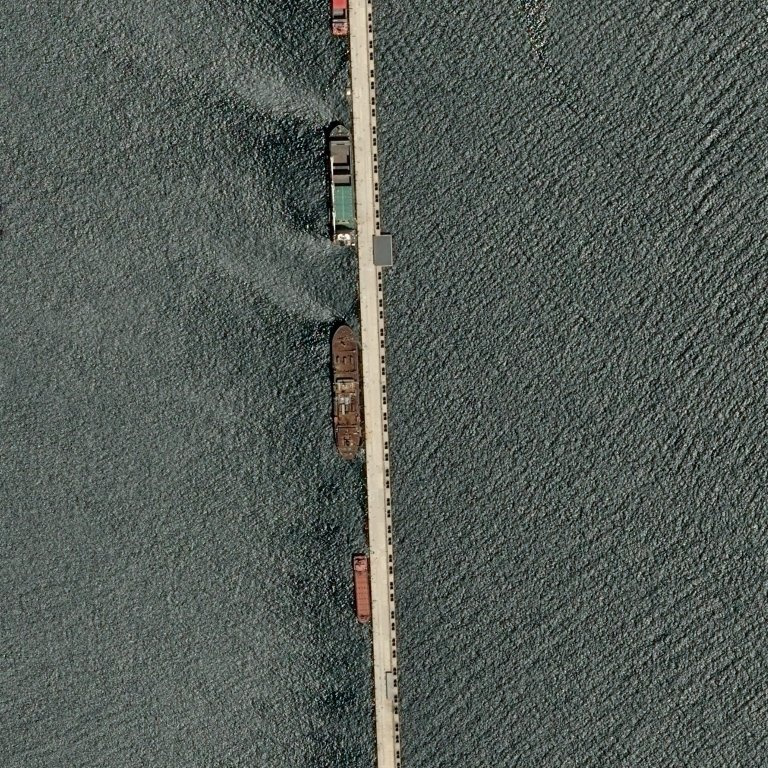

In [113]:
Image.open("../data/airbus-ship/test_v2/68dbdae55.jpg")

../data/airbus-ship/team_data/stacking/test_preds_1/68dbdae55.jpg.png


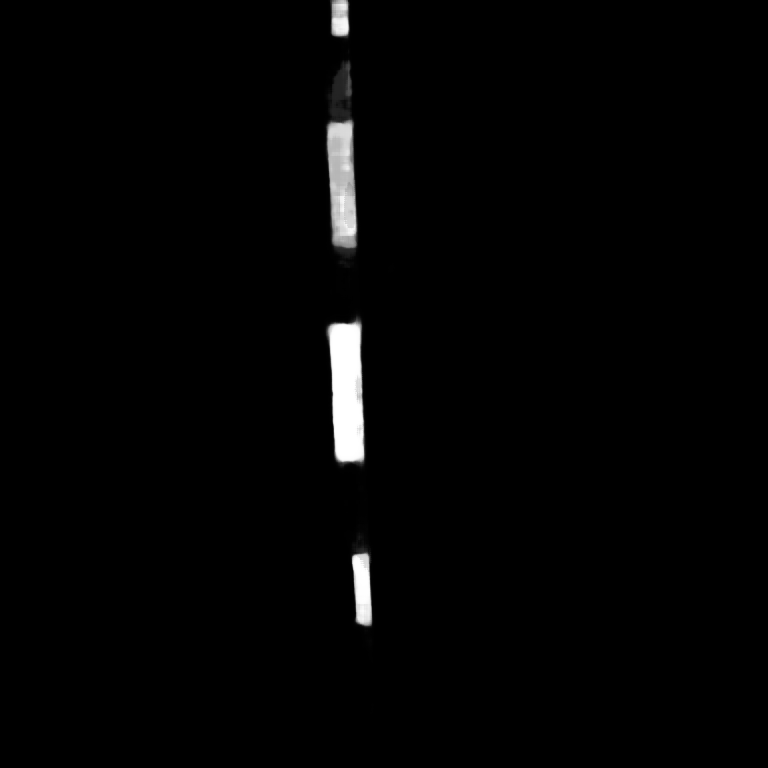

In [111]:
i = np.random.choice(range(len(test_preds_1)))
print(test_preds_1[i])
Image.open(test_preds_1[i])